## Importing libaries

In [1]:
import pandas as pd

from sklearn import preprocessing 
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics, neighbors
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import os
os.chdir('../Preprocessing')
from normalization import normalize_corpus


## Reading the data

In [2]:
df = pd.read_csv('../Data_collection/dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198125 entries, 0 to 198124
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  198125 non-null  int64 
 1   url         198125 non-null  object
 2   content     198125 non-null  object
 3   summary     197911 non-null  object
 4   category    198125 non-null  object
dtypes: int64(1), object(4)
memory usage: 7.6+ MB


## Normalizing the data

#### The implementation of this is available under normalization.py located in preprocessing folder

In [3]:
if not os.path.exists('../Data_collection/dataset_filtered.csv'):
    df['filtered_content'] = df['content'].apply(normalize_corpus)
    # df.to_csv('../Data_collection/dataset_filtered.csv')
    df.to_pickle('../Data_collection/dataset_filtered.pickle')
else:
    df = pd.read_csv('../Data_collection/dataset_filtered.csv')
df.head()

,Unnamed: 0,url,content,summary,category,filtered_content
0,0,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Paris/London/Atlanta: Federal Reserve Bank of ...,Paris/London/Atlanta: Federal Reserve Bank of ...,b,federal reserve bank philadelphia president ch...
1,1,http://www.nasdaq.com/article/plosser-fed-may-...,Women Who Invest: VC Include CEO\n\nAbout 14% ...,Women Who Invest: VC Include CEOAbout 14% of f...,b,woman who invest vc include ceo about fund man...
2,2,http://www.marketwatch.com/story/feds-plosser-...,PARISn — The Federal Reserve may have to accel...,PARISn — The Federal Reserve may have to accel...,b,parisn the federal reserve may accelerate pace...
3,3,http://www.fxstreet.com/news/forex-news/articl...,FXStreet (Łódź) - Philadelphia Fed President C...,FXStreet (Łódź) - Philadelphia Fed President C...,b,fxstreet łódź philadelphia fed president charl...
4,4,http://www.iii.co.uk/news-opinion/reuters/news...,Be up to £45k better off .\n\nResearch shows y...,Be up to £45k better off .\nResearch shows you...,b,be good research show could well year invest i...


/media/jlkcp/work/anaconda3/envs/8735/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Before sampling')

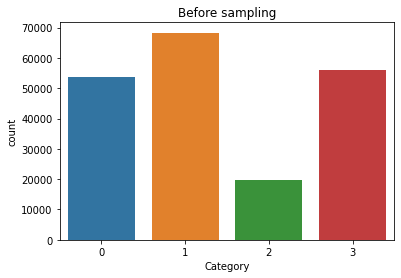

In [4]:
# Encode labels in column 'category'.
label_encoder = preprocessing.LabelEncoder() 
df['category']= label_encoder.fit_transform(df['category']) 

sns.countplot(df.category)
plt.xlabel('Category')
plt.ylabel('count')
plt.title('Before sampling')

/media/jlkcp/work/anaconda3/envs/8735/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'After sampling')

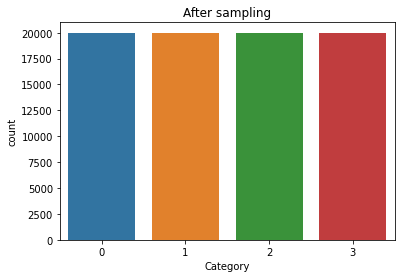

In [5]:
#Sampling the data

df0 = df[df.category==0]
df1 = df[df.category==1]
df2 = df[df.category==2]
df3 = df[df.category==3]

samples = df.category.value_counts().tolist()

sample_count = 20000

df0 = resample(df0, 
                   replace=True,   
                   n_samples=sample_count, 
                   random_state=1130)
df1 = resample(df1, 
                   replace=True,    
                   n_samples=sample_count,
                   random_state=123)
df2 = resample(df2, 
                   replace=True,    
                   n_samples=sample_count,
                   random_state=123)
df3 = resample(df3, 
                   replace=True,    
                   n_samples=sample_count,
                   random_state=123)


df_sampled = pd.concat([df0,df1,df2,df3])

df= df_sampled



sns.countplot(df_sampled.category)
plt.xlabel('Category')
plt.ylabel('count')
plt.title('After sampling')

## Feature Extraction using Bag of words

In [6]:
training_set, test_set, training_labels, test_labels = train_test_split(df["filtered_content"], df["category"], test_size=0.33, random_state=42)

#### Classification using Bag of words features

## Feature Extractiong using TF-IDF vector

In [7]:
#Tfidf 
tfidvectorizer = TfidfVectorizer(min_df=2, 
                                 ngram_range=(2,2),
                                 smooth_idf=True,
                                 use_idf=True)
tfid_train_features = tfidvectorizer.fit_transform(training_set)

tfid_test_features = tfidvectorizer.transform(test_set)

In [8]:
print(tfid_train_features.shape)
print(training_labels.shape)

(53600, 1273647)
(53600,)


In [9]:
tfid_train_features[1,:]

<1x1273647 sparse matrix of type '<class 'numpy.float64'>'
	with 309 stored elements in Compressed Sparse Row format>

In [10]:
import umap
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(tfid_train_features)

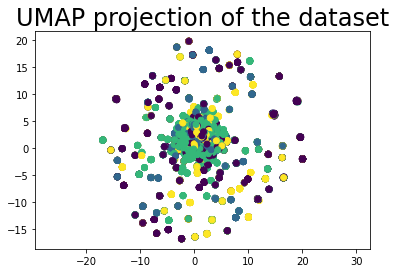

In [11]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=training_labels)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=24);

#### Classification using KNN taking TF-IDF features as inputs

In [12]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords

stopword_list = stopwords.words('english')
dtm = CountVectorizer(max_df=0.7, min_df=5, token_pattern="[a-z']+", 
                      stop_words=stopword_list, max_features=2000) # Only top 2000 most frequently ocurring words are considered
dtm.fit(training_set)

dtm_mat = dtm.transform(test_set)
tsvd = TruncatedSVD(n_components=200)
tsvd.fit(dtm_mat)
tsvd_mat = tsvd.transform(dtm_mat)
km = KMeans(n_clusters=4, n_init=50, max_iter=1000) # Instantiate KMeans clustering
km.fit(tsvd_mat) # Run KMeans clustering


KMeans(max_iter=1000, n_clusters=4, n_init=50)

In [13]:

acc = metrics.accuracy_score(test_labels, km.labels_)
print('Accuracy: {}'.format(str(acc * 100) + '%'))

Accuracy: 23.393939393939394%


In [14]:
tsvd = TruncatedSVD(n_components=200)
tsvd_mat = tsvd.fit(tfid_test_features)
km = KMeans(n_clusters=4, n_init=50, max_iter=1000) # Instantiate KMeans clustering
km.fit(tsvd_mat) # Run KMeans clustering


In [1]:
acc = metrics.accuracy_score(test_labels, km.labels_)
print('Accuracy: {}'.format(str(acc * 100) + '%'))

NameError: name 'metrics' is not defined

In [34]:
def knn(p, k, train_vec, y_train, test_vec, y_test, metric=None):
    
    knn = neighbors.NearestNeighbors(n_neighbors=k, algorithm='auto', metric=metric, p=p, n_jobs=1)
    knn.fit(train_vec)

    distances, indices = knn.kneighbors(test_vec, return_distance=True)
    distances
    return distances.ravel(), indices.ravel() 

    # knn.fit(train_vec, y_train)
    # predicted = knn.predict(test_vec)
    # acc = metrics.accuracy_score(y_test, predicted)
    # print('Accuracy: KNN, neighbors: {}, distance metric: {}  = {}'.format(k,metric, str(acc * 100) + '%'))

In [33]:
for n_neighbor in range(2,2,1):
    ttt1, ttt2 = knn(2,n_neighbor, tfid_train_features, training_labels, tfid_test_features, test_labels, 'cosine')

    ttt1

C:\Users\Hetal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hetal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression using TF-IDF

Accuracy:  94.72742881671198 

Classification Report

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      3583
           1       0.95      0.98      0.97      3422
           2       0.95      0.94      0.94      3442
           3       0.95      0.93      0.94      3531

    accuracy                           0.95     13978
   macro avg       0.95      0.95      0.95     13978
weighted avg       0.95      0.95      0.95     13978



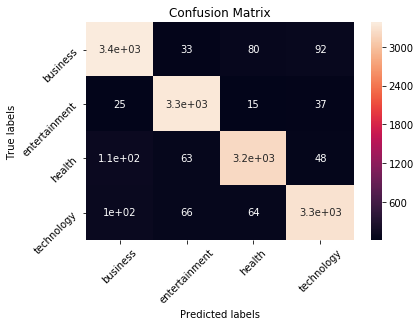

In [24]:


tfidf_model = vectorizer.fit_transform(texts)
km_model = KMeans(n_clusters=clusters)
km_model.fit(tfidf_model)
 
    
logRegModel = LogisticRegression()
logRegModel.fit(tfid_train_features,training_labels)

predictions_lr = logRegModel.predict(tfid_test_features)
score_lr = logRegModel.score(tfid_test_features,test_labels)

print("Logistic Regression using TF-IDF\n")
print("Accuracy: ",accuracy_score(predictions_lr, test_labels)*100,"\n")

print("Classification Report\n")
print(classification_report(test_labels,predictions_lr))


#Plotting the confusion matrix
cm = confusion_matrix(test_labels, predictions_lr)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['business', 'entertainment','health','technology'],rotation =45); 
ax.yaxis.set_ticklabels(['business', 'entertainment','health','technology'],rotation =45);


MultiNomial Naive Bayes using TF-IDF

Accuracy:  94.54142223494063 

Classification Report

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      3583
           1       0.96      0.98      0.97      3422
           2       0.95      0.94      0.94      3442
           3       0.94      0.93      0.94      3531

    accuracy                           0.95     13978
   macro avg       0.95      0.95      0.95     13978
weighted avg       0.95      0.95      0.95     13978



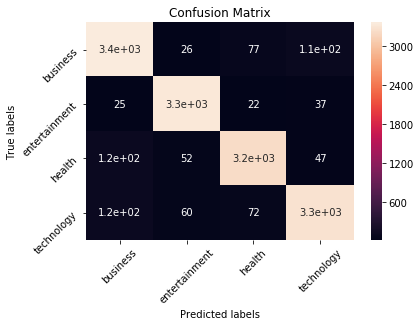

In [25]:
#Naive Bayes
mnb = MultinomialNB()

mnb.fit(tfid_train_features,training_labels)

predictions_mnb = mnb.predict(tfid_test_features)

print("MultiNomial Naive Bayes using TF-IDF\n")
print("Accuracy: ",accuracy_score(predictions_mnb, test_labels)*100,"\n")

print("Classification Report\n")
print(classification_report(test_labels,predictions_mnb))


#Plotting the confusion matrix
cm = confusion_matrix(test_labels, predictions_mnb)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['business', 'entertainment','health','technology'],rotation =45); 
ax.yaxis.set_ticklabels(['business', 'entertainment','health','technology'],rotation =45);


Random Forest using TF-IDF

Accuracy:  92.05894977822292 

Classification Report

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3583
           1       0.95      0.95      0.95      3422
           2       0.87      0.93      0.90      3442
           3       0.94      0.88      0.91      3531

    accuracy                           0.92     13978
   macro avg       0.92      0.92      0.92     13978
weighted avg       0.92      0.92      0.92     13978



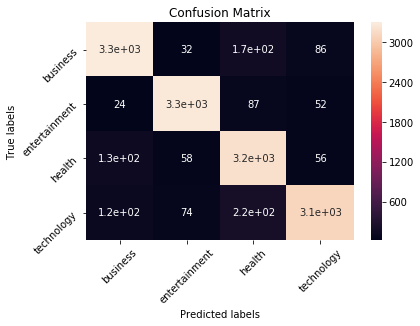

In [26]:
#Random Forest
rfc = RandomForestClassifier(n_estimators=10)

rfc.fit(tfid_train_features,training_labels)

predictions_rfc = rfc.predict(tfid_test_features)

print("Random Forest using TF-IDF\n")
print("Accuracy: ",accuracy_score(predictions_rfc, test_labels)*100,"\n")

print("Classification Report\n")
print(classification_report(test_labels,predictions_rfc))


#Plotting the confusion matrix
cm = confusion_matrix(test_labels, predictions_rfc)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['business', 'entertainment','health','technology'],rotation =45); 
ax.yaxis.set_ticklabels(['business', 'entertainment','health','technology'],rotation =45);

Support Vector Machine using IF-IDF

Accuracy:  95.26398626412934 

Classification Report

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      3583
           1       0.96      0.98      0.97      3422
           2       0.95      0.95      0.95      3442
           3       0.96      0.94      0.95      3531

    accuracy                           0.95     13978
   macro avg       0.95      0.95      0.95     13978
weighted avg       0.95      0.95      0.95     13978



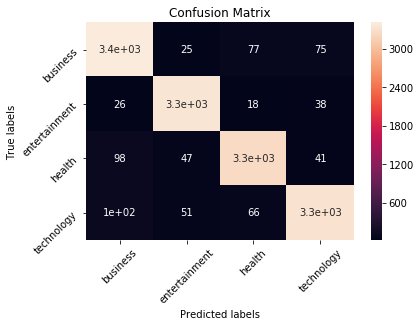

In [27]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(tfid_train_features,training_labels)

predictions_SVM = SVM.predict(tfid_test_features)


print("Support Vector Machine using IF-IDF\n")
print("Accuracy: ",accuracy_score(predictions_SVM, test_labels)*100,"\n")

print("Classification Report\n")
print(classification_report(test_labels,predictions_SVM))


#Plotting the confusion matrix
cm = confusion_matrix(test_labels, predictions_SVM)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['business', 'entertainment','health','technology'],rotation =45); 
ax.yaxis.set_ticklabels(['business', 'entertainment','health','technology'],rotation =45);


In [8]:
def knn(p,n,vector_type, metric=None):
        
    X_train, X_test, y_train, y_test = train_test_split(df["FILTERED_CONTENT"], df["CATEGORY"],
                                                        test_size=0.2, random_state=5)
    
    knn = neighbors.KNeighborsClassifier(n_neighbors=n, weights='distance', algorithm='auto', metric=metric, p=p, n_jobs=1)
    
    if vector_type == 'BoW':
        vectorizer = CountVectorizer(analyzer='word', input='content')
        train_vec = vectorizer.fit_transform(X_train)
        test_vec = vectorizer.transform(X_test)
    
    elif vector_type == 'tfidf':
        vectorizer =  TfidfVectorizer(analyzer='word', input='content')
        train_vec = vectorizer.fit_transform(X_train)
        test_vec = vectorizer.transform(X_test)

    

    knn.fit(train_vec, y_train)
    predicted = knn.predict(test_vec)
    acc = metrics.accuracy_score(y_test, predicted)
    print('Accuracy: KNN with {}, neighbors: {}, distance metric: {}  = {}'.format(vector_type, n,metric, str(acc * 100) + '%'))

In [11]:
for n_neighbor in range(2,8,1):
    knn(2,n_neighbor,'BoW','cosine')

Accuracy: KNN with BoW, neighbors: 2, distance metric: cosine  = 95.60923369823894%
Accuracy: KNN with BoW, neighbors: 3, distance metric: cosine  = 95.5140409328891%
Accuracy: KNN with BoW, neighbors: 4, distance metric: cosine  = 95.38315088053308%
Accuracy: KNN with BoW, neighbors: 5, distance metric: cosine  = 95.50214183722036%
Accuracy: KNN with BoW, neighbors: 6, distance metric: cosine  = 95.49024274155164%
Accuracy: KNN with BoW, neighbors: 7, distance metric: cosine  = 95.44264635887673%


In [13]:
for n_neighbor in range(2,8,1):
    knn(2,n_neighbor,'BoW','euclidean')

Accuracy: KNN with BoW, neighbors: 2, distance metric: euclidean  = 93.53879105188005%
Accuracy: KNN with BoW, neighbors: 3, distance metric: euclidean  = 93.14612089481199%
Accuracy: KNN with BoW, neighbors: 4, distance metric: euclidean  = 93.27701094716801%
Accuracy: KNN with BoW, neighbors: 5, distance metric: euclidean  = 93.16991908614945%
Accuracy: KNN with BoW, neighbors: 6, distance metric: euclidean  = 93.2294145644931%
Accuracy: KNN with BoW, neighbors: 7, distance metric: euclidean  = 92.78914802475012%


In [12]:
for n_neighbor in range(2,8,1):
    knn(2,n_neighbor,'tfidf','euclidean')

Accuracy: KNN with tfidf, neighbors: 2, distance metric: euclidean  = 95.76392194193242%
Accuracy: KNN with tfidf, neighbors: 3, distance metric: euclidean  = 95.7163255592575%
Accuracy: KNN with tfidf, neighbors: 4, distance metric: euclidean  = 95.65683008091385%
Accuracy: KNN with tfidf, neighbors: 5, distance metric: euclidean  = 95.76392194193242%
Accuracy: KNN with tfidf, neighbors: 6, distance metric: euclidean  = 95.76392194193242%
Accuracy: KNN with tfidf, neighbors: 7, distance metric: euclidean  = 96.01380295097573%


In [14]:
for n_neighbor in range(2,8,1):
    knn(2,n_neighbor,'tfidf','cosine')

Accuracy: KNN with tfidf, neighbors: 2, distance metric: cosine  = 95.76392194193242%
Accuracy: KNN with tfidf, neighbors: 3, distance metric: cosine  = 95.70442646358876%
Accuracy: KNN with tfidf, neighbors: 4, distance metric: cosine  = 95.78772013326987%
Accuracy: KNN with tfidf, neighbors: 5, distance metric: cosine  = 95.85911470728225%
Accuracy: KNN with tfidf, neighbors: 6, distance metric: cosine  = 95.94240837696336%
Accuracy: KNN with tfidf, neighbors: 7, distance metric: cosine  = 96.03760114231319%
